# BART on Google Colab

**Author**:  
Nick Scholand, [nick.scholand@med.uni-goettingen.de](mailto:nick.scholand@med.uni-goettingen.de)  
Christian Holme, [christian.holme@med.uni-goettingen.de](mailto:christian.holme@med.uni-goettingen.de)


**Institution**: University Medical Center Göttingen


## Choose GPU
  
Choose a GPU instance for this tutorial:

- Go to Edit → Notebook Settings
- choose GPU from Hardware Accelerator drop-down menu


## Check GPU Hardware

In the beginning of this tutorial we need to check which GPU type we got from Google Colab. Free users are provided with either a **Tesla T4**, a **Tesla P100-PCIE-16GB** or a **Tesla K80** GPU.

While the Tesla T4 and Tesla P100-PCIE-16GB support the default CUDA 11 version, the Tesla K80 does not.

If you got a K80 assigned to, the following lines will reset your default CUDA to version 10.1, which should work afterwards.

In [1]:
%%bash

# Estimate GPU Type
GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

echo "GPU Type:"
echo $GPU_NAME

if [ "Tesla K80" = "$GPU_NAME" ];
then
    echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."

    # Install CUDA-10.1 if not already installed
    apt-get install cuda-10-1 cuda-drivers &> /dev/null

    # Change default CUDA to version 10.1
    cd /usr/local
    rm cuda
    ln -s cuda-10.1 cuda

else
    echo "GPU Information:"
    nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
    nvcc --version
    echo "Current GPU supports default CUDA-11."
    echo "No further actions are necessary."
fi

GPU Type:
Tesla K80
GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1.


In [2]:
import os

# Set Library path for current CUDA version
os.environ['LD_LIBRARY_PATH'] = "/usr/local/cuda/lib64"

## Install BART

If you have BART already installed on your system, [skip →](#python) BARTs installation part.

To install [BART](https://github.com/mrirecon/bart/tree/master) we need some special dependencies. Let us install them on your chosen system.

In [3]:
%%bash

# Install BARTs dependencies

apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

After installing BARTs dependencies we now want to get the latest BART version from its [GitHub repository](https://github.com/mrirecon/bart/tree/master).

In [4]:
%%bash

# Download BART version

[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart

[ -d "bart" ] && echo "BART branch ${BRANCH} was downloaded successfully."

BART branch  was downloaded successfully.


Cloning into 'bart'...


In the next step we are going to compile BART. Ensure that the correct references to your CUDA instance 

- `CUDA`
- `CUDA_BASE`
- `CUDA_LIB`

are chosen! The default is set to work on [Google Colab](https://colab.research.google.com).

In [5]:
%%bash

cd bart

# Switch to desired branch of the BART project
BRANCH="master"
git checkout $BRANCH

# Define specifications 
COMPILE_SPECS=" PARALLEL=4
                CUDA=1
                CUDA_BASE=/usr/local/cuda
                CUDA_LIB=lib64"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

# Compile BART with CUDA
make &> /dev/null

cd ..

Your branch is up to date with 'origin/master'.


Already on 'master'


## Set Environment for BART

After downloading and compiling BART, the next step simplifies the handling of BARTs command line interface inside of a ipyhton jupyter-notebook.



In [6]:
import os
import sys

# Define environment variables for BART and OpenMP

os.environ['TOOLBOX_PATH'] = "/content/bart"

os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable

os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")

Now BART can be called by

In [7]:
%%bash
bart

BART. Available commands are:
avg         bench       bin         bitmask     cabs        caldir      
calmat      carg        casorati    cc          ccapply     cdf97       
circshift   conj        conv        conway      copy        cpyphs      
creal       crop        delta       ecalib      ecaltwo     epg         
estdelay    estdims     estshift    estvar      extract     fakeksp     
fft         fftmod      fftrot      fftshift    filter      flatten     
flip        fmac        homodyne    index       invert      itsense     
join        looklocker  lrmatrix    mandelbrot  mip         moba        
mobafit     nlinv       noise       normalize   nrmse       nufft       
ones        pattern     phantom     pics        pocsense    poisson     
pol2mask    poly        repmat      reshape     resize      rmfreq      
rof         roistat     rss         rtnlinv     sake        saxpy       
scale       sdot        show        signal      slice       spow        
sqpics      squeeze  

<a name="python"></a>
## Install Python Dependencies


Additionally to the installation of BART, we need some python libraries for visualizations and data handling.

In [8]:
import cfl
import numpy as np

from IPython.display import Image

# Example: Running BART on Google Colabs GPUs

In [22]:
%%bash

SAMPLES=384
SPOKES=91

# Create a radial trajectory to work with

bart traj -x $SAMPLES -y $SPOKES -r -D -l t
bart scale 0.5 t t2

head -n2 t2.hdr

# Dimensions
3 384 91 1 1 1 1 1 1 1 1 1 1 1 1 1 


In [23]:
%%bash

# Create a Cartesian phantom

bart phantom -k -s 8 -t t2 k

head -n2 k.hdr

# Dimensions
1 384 91 8 1 1 1 1 1 1 1 1 1 1 1 1 


In [24]:
%%bash

# Estimate the perfect coil-profiles

bart phantom -x192 -S8 coils

head -n2 coils.hdr

# Dimensions
192 192 1 8 1 1 1 1 1 1 1 1 1 1 1 1 


In [25]:
%%bash

# Reshape Coils to plot 2D image
bart reshape $(bart bitmask 1 3) $((192*8)) 1 coils coils_flat

bart toimg -W coils_flat coils_flat.png

Writing 1 image(s)...done.


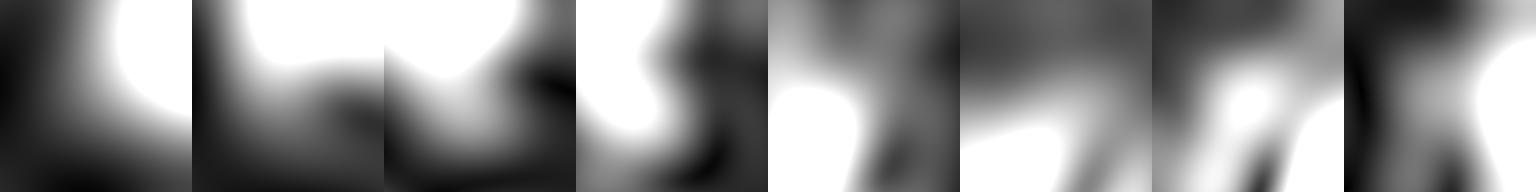

In [26]:
# Visualize coils
Image('coils_flat.png')

In [27]:
%%bash

# Perform an nuFFT reconstruction on the GPU...

bart nufft -g -i t2 k reco_nufft
head -n2 reco_nufft.hdr

# ...and combine all coil images

bart rss $(bart bitmask 3) reco_nufft reco_n
head -n2 reco_n.hdr

Est. image size: 192 192 1
Done.
# Dimensions
192 192 1 8 1 1 1 1 1 1 1 1 1 1 1 1 
# Dimensions
192 192 1 1 1 1 1 1 1 1 1 1 1 1 1 1 


Writing 1 image(s)...done.


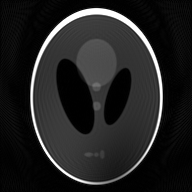

In [28]:
# Visualize nufft reconstruction
!bart toimg -W reco_n reco_n.png
Image('reco_n.png')

In [29]:
%%bash
# Perform a Parallel-Imaging Compressed Sensing Reconstruction on GPU
bart pics -g -e -t t2 k coils reco_pics

GPU reconstruction
[  1 384  91   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[192 192   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
Maximum eigenvalue: 2.85e+12
conjugate gradients
Total Time: 2.166818


Writing 1 image(s)...done.


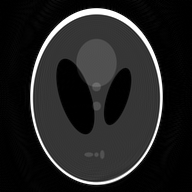

In [30]:
# Visualize PICS reconstruction
!bart toimg -W reco_pics reco_pics.png
Image('reco_pics.png')

In [31]:
%%bash

# Clean up
rm *.cfl *.hdr